The research was supported by the Ministry of Innovation and Technology NRDI Office within the framework of the MILAB Artificial Intelligence National Laboratory Program.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
import uproot

def read_root(file):
    f = uproot.open(file)
    tree = f[f.keys()[0]]
    dfH = pd.DataFrame(tree.arrays(library='np', how=tuple)).transpose()
    dfH.columns =tree.keys()
    f.close()
    return dfH

def gauss(x,m,sig):
    return np.exp(-(xx-m)*(xx-m)/(2.*sig*sig))/np.sqrt(2.*np.pi*sig*sig)

def get_sigma(df,sig):
    sig = np.std(df[np.abs(df)<3*sig])
    return np.std(df[np.abs(df)<2.5*sig])


- Goal: get "realistic" detector readout for NN training
- MC just tells us, "there is a particle in the sensitive layer of the detector depositing there $E_{dep}$ energy"
- in the detector the charge diffusion activates multiple pixels (cluster) depending on $E_{dep}$
- detector geometry has dead zones, overlaps, chip boundaries

![Detector Panel blueprint](CarbonCarrierWithCables_B.png)

In [1]:
import numpy as np
import pandas as pd
import uproot

class ConvertToPixels:
    ChipSize = np.array([30., 15.]) # ALPIDE is a 30 mm x 15 mm chip
    PixelSize = np.array([0.02924,0.02688]) # pixelsize on ALPIDE
    # board contains 9 x 12 chips. The 12 chips are positioned in double layer 6-6 chips, with overlap overY \approx 0.1mm
    padX = 0.02912 # X padding: 29.12 micron
    Xgap = 0.1 # gap between ALPIDEs in X direction

    padY = 0.02944 # Y padding: 29.44 micron on the opposite to eletronics end
    Ygap = 27.4 # distance between stripes in Y direction: 27.4 mm
    overY = 0.092 # overlap between F/B: 0.092 mm on both ends
    ElectrY = 1.208 # electronics part on the chip 1.208 mm (only one side, no padding here)
    Yshift = 0.85 # in Y direction the first chip starts at 0.85 mm (positive half)
    Ydif = 0.1 # for the negative half plane the first chip starts at 0.95 mm = 0.85 + Ydif
    
    ChipX = np.array([-ChipSize[0]/2+padX, ChipSize[0]/2-padX])
    ChipFY = np.array([Yshift + padY,Yshift + ChipSize[1] -ElectrY])
    YSize = (ChipFY[1] - ChipFY[0])/2. # 'radius' of the sensitive area (mm)
    ChipMidYF = (ChipFY[0]+ChipFY[1])/2
    ChipBY = np.array([Yshift + ChipSize[1] -ElectrY - overY + padY,Yshift + 2*ChipSize[1] -2*ElectrY - overY])
    ChipMidYB = (ChipBY[0]+ChipBY[1])/2.

    Xmin = 0
    Xmax = 1023
    Ymin = 0
    Ymax = 511
    
    Xmed = np.zeros(9) # middle of chip X positions, 9 chips 
    YmedF = np.zeros(6) # middle of "front" Y positions: 6 chips
    YmedB = np.zeros(6) # middle of "back" Y positions: 6 chips

    # cluster parameters (circleX, circleY Short_t circleX/Y[70])
    # See Helge's https://github.com/HelgeEgil/DigitalTrackingCalorimeterToolkit repo and Thesis
    circleX = [0,1,0,-1,0,1,-1,-1,1,0,-2,0,2,1,-2,-1,2,-1,-2,1,2,-2,-2,2,2,0,-3,0,3,-1,-3,1,3,1,-3,-1,3,0,-4,0,4,2,-3,-2,3,-8,-2,-3,2,4,-1,-4,1,4,1,7,-1,3,3,-3,-3,4,2,-4,-2,4,-2,2,5,0];
    circleY = [0,0,-1,0,1,-1,-1,1,1,-2,0,2,0,-2,-1,2,1,-2,1,2,-1,-2,2,2,-2,-3,0,3,0,-3,1,3,-1,-3,-1,3,1,-4,0,4,0,-3,-2,3,2,15,-3,2,3,-1,-4,1,4,1,-4,-18,4,3,-3,-3,3,2,-4,-2,4,-2,-4,4,0,5];
    binPosLUT = [1,2,4,8,16,32,64,128,256,512,1024,2048,4096]

    def __init__(self,CDIR):
        self.Xmed = np.linspace(-4.*(self.ChipSize[0]+self.Xgap),4.*(self.ChipSize[0]+self.Xgap),9)
        self.YmedF = np.array((-83.15+self.padY-83.15+self.ChipSize[1]-self.ElectrY)/2+np.arange(6)*27.4)
        self.YmedF[3:] += 2*self.Yshift+self.Ydif
        self.YmedB = self.YmedF + 27.4/2
        self.PosZ = np.concatenate([[225.219,225.219+52.4],333.369+5.5*np.arange(0.,48.,1.)])  # Z position of Layers
        
        file = uproot.open(CDIR+f'\\database_final_reduced.root')
        tree = file[file.keys()[0]]
        self.CSconfigs = pd.DataFrame(tree.arrays(library='np', how=tuple)).transpose()
        self.CSconfigs.columns =tree.keys()
        file.close()
        self.CSindex = pd.read_csv(CDIR+f'\\sortIndex.csv',sep=' ',header=0,names=['cs','start'])
        
        self.tol = 0.001 # tolerance of positioning layer to posZ

    
    def get_Pos(self,X,Y,Edep):
        res = np.empty((2,4),dtype=int); res.fill(-1)
        col = np.argmin(np.abs(X-self.Xmed)) # selects chip (column)
        pX = (X+self.ChipX[1]-self.Xmed[col])/self.PixelSize[0]
        iX = np.floor(pX) # should be between 0 and 1023 for valid hit

        df = pd.DataFrame(columns=['col','row','X','Y','edep'],dtype=float)
        if(iX >= self.Xmin and iX <= self.Xmax):
            row = np.argmin(np.abs(Y-self.YmedF)) # selects chip (column)
            pY = (self.YSize+(Y-self.YmedF[row]))/self.PixelSize[1]  
            iY = np.floor(pY)  # should be between 0 and 511 for valid hit
            if(iY >= self.Ymin and iY <= self.Ymax):
                df = df.append({'col': col, 'row': 2*row, 'X': pX, 'Y': pY, 'edep': Edep}, ignore_index=True)
            row = np.argmin(np.abs(Y-self.YmedB)) # selects chip (column)
            pY = (self.YSize+(Y-self.YmedB[row]))/self.PixelSize[1]
            iY = np.floor(pY)  # should be between 0 and 511 for valid hit
            if(iY >= self.Ymin and iY <= self.Ymax):
                df = df.append({'col': col, 'row': 2*row+1, 'X': pX, 'Y': pY, 'edep': Edep}, ignore_index=True)
        return df
    
    def get_Pos_multi(self,ps):  # receives a list of X,Y pairs
#        return np.vstack([y for y in [self.get_Pos(p[0],p[1]) for p in ps] if 0 not in y.shape])
        df = pd.DataFrame(columns=['col','row','X','Y','edep'],dtype=float)
        for p in ps:
            df = df.append(self.get_Pos(p[0],p[1],p[2]))
        return df

    def get_Coords(self,p):
        X = p[2]*self.PixelSize[0] + self.Xmed[int(p[0])] - self.ChipX[1]
        j = int(p[1] // 2); back = int(p[1] % 2)
        Ymed = self.YmedF[j]
        if(back == 1):
            Ymed = self.YmedB[j]
        Y = Ymed - self.YSize + p[3]*self.PixelSize[1]
        return [X,Y]
    
    def get_CS(self,Edeps): # ps is [pX,pY,Edep]
        return [int(np.floor(4.2267 * (Edep*40.)**0.65 + 0.5)) for Edep in Edeps]
        
    def set_CS_multi(self,ps): # ps is [pX,pY,Edep]
        df = pd.DataFrame(columns=['iX','iY'],dtype=int)
        for p in ps:
            CS = np.floor(4.2267 * (p[2]*40.)**0.65 + 0.5)
            if(CS < 2): # cluster sizes less than 1 are under threshold
                continue
            if(CS < 26):  # use library for shapes. THIS WAS 27 in Helges's code, however CSindex[26] == CSindex[25] ?!
                id = np.random.randint(self.CSindex['start'][CS-1],self.CSindex['start'][CS])
                x_mean = self.CSconfigs['x_mean'][id]
                y_mean = self.CSconfigs['y_mean'][id]
                CSarray = self.CSconfigs['hit_array'][id]
                for i in range(10):              
                    for j in range(10):
                        if(CSarray[i] & self.binPosLUT[j]):
                            outX = np.floor(p[0] + int(np.floor(i-x_mean+0.5)))
                            outY = np.floor(p[1] + int(np.floor(j-y_mean+0.5)))
                            if(outX >= self.Xmin and outX <= self.Xmax and outY >= self.Ymin and outY <= self.Ymax):
                                df=df.append({'iX': outX, 'iY': outY}, ignore_index=True)
                continue
            CS = int(min(CS,70))  # max cluster size is 70
            for i in range(CS):
                outX = np.floor(p[0] + self.circleX[i]+0.5)
                outY = np.floor(p[1] + self.circleY[i]+0.5)
                if(outX >= self.Xmin and outX <= self.Xmax and outY >= self.Ymin and outY <= self.Ymax):
                    df=df.append({'iX': outX, 'iY': outY}, ignore_index=True)
        return df
    
    def get_Layer(self,Zs):
        return [np.sum(z > self.PosZ - self.tol)-1 for z in Zs]
    
    def get_Layer_Pos(self):  # return the Z positions of Layers
        return self.PosZ
    
Cp = ConvertToPixels(f'Data\\Cluster\\')
for X,Y,Edep in zip([45.02,213.6,37.4,37.4],[-14.6,34.7,23.5,186.3],[0.001,0.005,0.01,0.015]):
    print('({0:6.2f},{1:6.2f}) => '.format(X,Y), [[ [row['col'],row['row'],row['X'],row['Y']] for index,row in Cp.get_Pos(X,Y,Edep).iterrows()]])


( 45.02,-14.60) =>  [[[5.0, 4.0, 1022.259917920657, 510.43750000000034], [5.0, 5.0, 1022.259917920657, 0.7648809523813703]]]
(213.60, 34.70) =>  [[]]
( 37.40, 23.50) =>  [[[5.0, 7.0, 761.6580027359784, 331.8660714285721]]]
( 37.40,186.30) =>  [[]]


### Pencil beam ?

In [38]:
dfH = read_root(f'Data\\MC\\head_phantom_10000Primaries_230MeV_1617471898.root')
dfAm450 = read_root(f'Data\\MC\\MyActorFile-450.root')
dfAm200 = read_root(f'Data\\MC\\MyActorFile-200.root')
#dfAm50 = read_root(f'C:\\Users\\Gábor\\Downloads\\pCT\\MyActorFile-50.root')
dfA0 = read_root(f'Data\\MC\\MyActorFile0.root')
dfA200 = read_root(f'Data\\MC\\MyActorFile200.root')
#CSconfigs = read_root(f'C:\\Users\\Gábor\\Downloads\\pCT\\database_final_reduced.root')
#CSindex = pd.read_csv(f'C:\\Users\\Gábor\\Downloads\\pCT\\sortIndex.csv',sep=' ',header=0,names=['cs','start'])
dfH['Layer'] = Cp.get_Layer(dfH['posZ'])

NameError: name 'Cp' is not defined

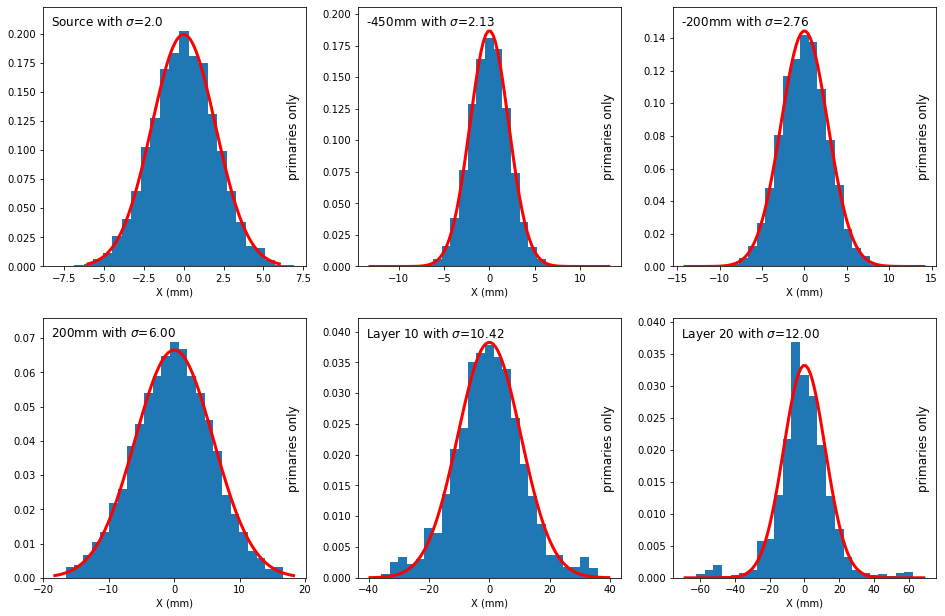

In [4]:
sh = 4
Layers = max(dfH['Layer'])
sigs = np.zeros(Layers+sh+1)

fig, ax = plt.subplots(2,3,figsize=(16,10.5))

sig = 2.
ttH = dfH[dfH['parentID']==0]
ax[0,0].hist(ttH['sourcePosX'],bins=25,density=True)
xx = np.linspace(-6,6,100)
yy = np.exp(-xx*xx/(2.*sig*sig))/np.sqrt(2.*np.pi*sig*sig)
ax[0,0].plot(xx,yy,'r',lw=3)
ax[0,0].text(0.03,0.97,r'Source with $\sigma$={}'.format(sig),horizontalalignment='left',verticalalignment='top',transform=ax[0,0].transAxes,fontsize=12)
ax[0,0].text(0.98,0.5,'primaries only',horizontalalignment='right',verticalalignment='center',transform=ax[0,0].transAxes,rotation=90,fontsize=12)
ax[0,0].set_xlabel('X (mm)')
ax[0,0].set_ylim(0,1.05*ax[0,0].get_ylim()[1])
sigs[0] = sig

ii=1
for df,d in zip([dfAm450,dfAm200,dfA200],[-450,-200,200]):
    tt = df[df['ParentID']==0]
    i = ii // 3; j = ii % 3 
    ax[i,j].hist(tt['X'],bins=25,density=True,range=(-6*sig,6*sig))
    xx = np.linspace(ax[i,j].get_xlim()[0],ax[i,j].get_xlim()[1],100)
    sig = np.std(tt[np.abs(tt['X'])<ax[i,j].get_xlim()[1]]['X'])
    ax[i,j].plot(xx,gauss(xx,0.,sig),'r',lw=3)
    ax[i,j].text(0.03,0.97,r'{0}mm with $\sigma$={1:.2f}'.format(d,sig),horizontalalignment='left',verticalalignment='top',transform=ax[i,j].transAxes,fontsize=12)
    ax[i,j].text(0.98,0.5,'primaries only',horizontalalignment='right',verticalalignment='center',transform=ax[i,j].transAxes,rotation=90,fontsize=12)
    ax[i,j].set_xlabel('X (mm)')
    ax[i,j].set_ylim(0,1.05*ax[i,j].get_ylim()[1])
    sigs[ii] = sig
    ii += 1
    
for Layer in [10,20]:
    tt = dfH[(dfH['Layer']==Layer) & (dfH['primaryID']==1)]
    i = ii // 3; j = ii % 3 
    ax[i,j].hist(tt['posX'],bins=25,density=True,range=(-6*sig,6*sig))
    xx = np.linspace(ax[i,j].get_xlim()[0],ax[i,j].get_xlim()[1],100)
    sig = np.std(tt[np.abs(tt['posX'])<ax[i,j].get_xlim()[1]]['posX'])
    sig = np.std(tt[np.abs(tt['posX'])<2.5*sig]['posX'])
    ax[i,j].plot(xx,gauss(xx,0.,sig),'r',lw=3)
    ax[i,j].text(0.03,0.97,r'Layer {0} with $\sigma$={1:.2f}'.format(Layer,sig),horizontalalignment='left',verticalalignment='top',transform=ax[i,j].transAxes,fontsize=12)
    ax[i,j].text(0.98,0.5,'primaries only',horizontalalignment='right',verticalalignment='center',transform=ax[i,j].transAxes,rotation=90,fontsize=12)
    ax[i,j].set_xlabel('X (mm)')
    ax[i,j].set_ylim(0,1.05*ax[i,j].get_ylim()[1])
    ii += 1


In [5]:
# spread of primaries only
ii = 4
for Layer in np.arange(Layers+1):
    sigs[ii] = get_sigma(dfH[(dfH['Layer']==Layer) & (dfH['parentID']==0)]['posX'],sigs[ii-1])
    ii += 1

In [6]:
# spread of ALL particles
sig = 2.
sigsAll = np.zeros(Layers+sh+1)
sigsAll[0] = get_sigma(dfH['sourcePosX'],sig) 

ii=1
for df in [dfAm450,dfAm200,dfA200]:
    sigsAll[ii] = get_sigma(df['X'],sigsAll[ii-1])
    ii += 1

for Layer in np.arange(Layers+1):
    sigsAll[ii] = get_sigma(dfH[(dfH['Layer']==Layer)]['posX'],sigsAll[ii-1])
    ii += 1

In [7]:
# number of hits in the subsequent layers
NumHitsAll = [len(dfH[dfH['Layer']==L]['posX']) for L in range(50)]
NumHitsPrimary = [len(dfH[(dfH['Layer']==L) & (dfH['parentID']==0)]['posX']) for L in range(50)]

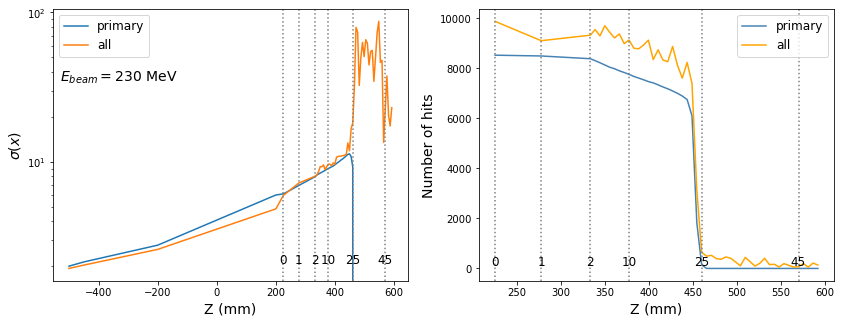

In [8]:
Layer_Pos = Cp.get_Layer_Pos()

fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].plot(np.concatenate([[-500,-450,-200,200],Layer_Pos]),sigs,label='primary')
ax[0].plot(np.concatenate([[-500,-450,-200,200],Layer_Pos]),sigsAll,label='all')
ax[0].set_xlabel('Z (mm)', fontsize=14)
ax[0].set_ylabel(r'$\sigma(x)$', fontsize=14)
ax[0].set_yscale('log')
ax[0].text(0.02,0.72,r'$E_{beam}=230$ MeV',horizontalalignment='left', verticalalignment='bottom', transform=ax[0].transAxes, fontsize=14)
ax[0].legend(fontsize=12)

ax[1].plot(Layer_Pos,NumHitsPrimary,label='primary', color='steelblue')
ax[1].plot(Layer_Pos,NumHitsAll,label='all', color='orange')
ax[1].set_xlabel('Z (mm)', fontsize=14)
ax[1].set_ylabel('Number of hits', fontsize=14)
ax[1].legend(fontsize=12)

for L in [0,1,2,10,25,45]:
    ax[0].axvline(x=Layer_Pos[L], ls='dotted', color='grey')
    ax[0].text(Layer_Pos[L],2,'{}'.format(L),horizontalalignment='center', verticalalignment='bottom', fontsize=12)
    ax[1].axvline(x=Layer_Pos[L], ls='dotted', color='grey')
    ax[1].text(Layer_Pos[L],2,'{}'.format(L),horizontalalignment='center', verticalalignment='bottom', fontsize=12)


plt.show()

So in calorimetric layers the spread is already considerable ($\sigma\approx 10$ mm means that we are covering already $\approx$ two chips in $y$ extension and one chip in x extension), and in the "secondaries" region the spread is quite high ($\approx 60$mm), covering 6x12 chips (however, usually do not survive the clusterization)!

In [9]:
# get all the valid hits on ALPIDE with edep > 25 keV at Layer Layer
Layer = 10
EdepCut = 0.025 #MeV
tdf = dfH[(dfH['Layer']==Layer) & (dfH['edep'] > EdepCut)]
#Hits = [t.get_Pos(X,Y) for X,Y,edep in zip(tdf['posX'],tdf['posY'],tdf['edep']) if edep > 0.025]
##Hits = [t.get_Pos(X,Y) for X,Y in zip([45.02,213.6,37.4,37.4],[-14.72,34.7,23.5,186.3])]
#Hits = np.vstack([y for y in Hits if 0 not in y.shape])
Hits = Cp.get_Pos_multi(zip(tdf['posX'],tdf['posY'],tdf['edep']))

# transform back the real hits to the coordinate system
RHits = pd.DataFrame([Cp.get_Coords([p['col'],p['row'],p['X'],p['Y']]) for index,p in Hits.iterrows()],columns=['X','Y'])

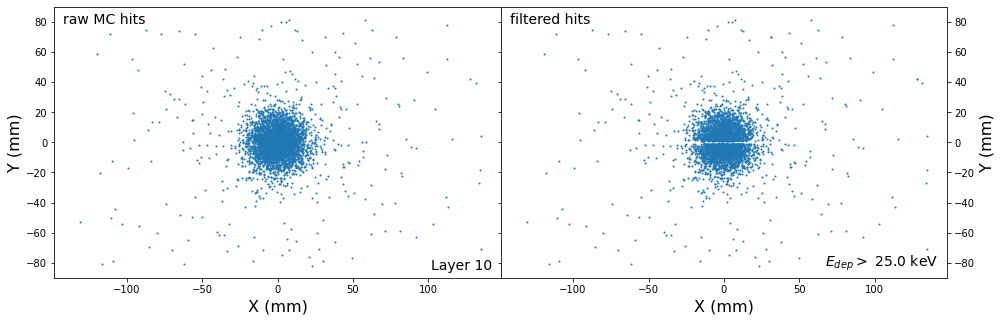

In [10]:
fig, ax = plt.subplots(1,2,figsize=(16,5.5), sharey=True)
plt.subplots_adjust(wspace=0)

ax[0].scatter(tdf['posX'],tdf['posY'],s=1)
ax[0].set_xlabel('X (mm)', fontsize=16)
ax[0].set_ylabel('Y (mm)', fontsize=16)
ax[0].set_aspect(1)
ax[0].text(0.02,0.98,'raw MC hits',horizontalalignment='left',verticalalignment='top',transform=ax[0].transAxes,fontsize=14)
ax[0].text(0.98,0.02,'Layer {}'.format(Layer),horizontalalignment='right',verticalalignment='bottom',transform=ax[0].transAxes,fontsize=14)

ax[1].scatter(RHits['X'],RHits['Y'],s=1)
ax[1].set_xlabel('X (mm)', fontsize=16)
ax[1].set_ylabel('Y (mm)', fontsize=16)
ax[1].set_aspect(1)
ax[1].text(0.02,0.98,'filtered hits',horizontalalignment='left',verticalalignment='top',transform=ax[1].transAxes,fontsize=14)
ax[1].text(0.98,0.02,r'$E_{{dep}} >$ {0} keV'.format(EdepCut*1000),horizontalalignment='right',verticalalignment='bottom',transform=ax[1].transAxes,fontsize=14)
ax[1].yaxis.set_label_position('right')
ax[1].tick_params(axis='y', which='both', labelleft=False, labelright=True, left=True, right=True)

xm = np.amax(np.abs(ax[0].get_xlim()+ax[1].get_xlim()))
ym = np.amax(np.abs(ax[0].get_ylim()+ax[1].get_ylim()))
ax[0].set_xlim(-xm,xm); ax[1].set_xlim(-xm,xm)
ax[0].set_ylim(-ym,ym); ax[1].set_ylim(-ym,ym)
plt.show()

In [11]:
chipX = 4
chipY = 6
Layer = 10
dfL10 = dfH[(dfH['Layer']==Layer)]
Ht = Cp.get_Pos_multi(zip(dfL10['posX'],dfL10['posY'],dfL10['edep']))
SHitsL10_46 = Ht[(Ht['col'] == 4) & (Ht['row'] == 6)]
SHitsL10_45 = Ht[(Ht['col'] == 4) & (Ht['row'] == 5)]
SHitsL10_56 = Ht[(Ht['col'] == 5) & (Ht['row'] == 6)]
SHitsL10_55 = Ht[(Ht['col'] == 5) & (Ht['row'] == 5)]

In [1115]:
# old format (get_Pos was returning a 0,1 or 2 line array, now it is returning a dataframe) , thats a bit trickier to get now
Layer = 10
dfL10 = dfH[(dfH['Layer']==Layer)]
Ht = [t.get_Pos(X,Y) for X,Y,edep in zip(dfL10['posX'],dfL10['posY'],dfL10['edep'])]
tt0 = [y for y in Ht if y.shape[0] == 0]
tt1 = [y for y in Ht if y.shape[0] == 1]
tt2 = [y for y in Ht if y.shape[0] == 2]
print('"Visual widht" is +- 30 mm, covering 4 chips in y and 2 (3) chips in x direction')
print('in Layer {0} Single hit: {1:.2f}% ({2}), No hit: {3:.2f}% ({4}), Double hit: {5:.2f}% ({6})'.format(
    Layer,100.*len(tt1)/len(Ht),len(tt1),100.*len(tt0)/len(Ht),len(tt0),100.*len(tt2)/len(Ht),len(tt2)))

"Visual widht" is +- 30 mm, covering 4 chips in y and 2 (3) chips in x direction
in Layer 10 Single hit: 99.06% (8461), No hit: 7.66% (654), Double hit: 0.16% (14)


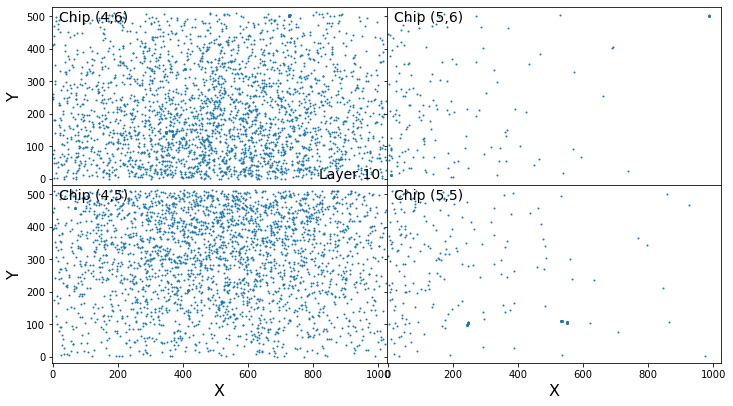

In [12]:
fig, ax = plt.subplots(2,2,figsize=(12,6.55),sharey=True, sharex=True)
plt.subplots_adjust(wspace=0, hspace=0)

plt.xlim(-2,1025)
#plt.ylim(0,511)

ax[0,0].scatter(SHitsL10_46['X'],SHitsL10_46['Y'],s=1)
ax[0,0].set_aspect(1)
ax[0,0].set_ylabel('Y', fontsize=16)
ax[0,0].set_ylim(-18,529)
ax[0,0].text(0.02,0.98,'Chip ({0},{1})'.format(4,6),horizontalalignment='left',verticalalignment='top',transform=ax[0,0].transAxes,fontsize=14)
ax[0,0].text(0.98,0.02,'Layer {}'.format(Layer),horizontalalignment='right',verticalalignment='bottom',transform=ax[0,0].transAxes,fontsize=14)

ax[0,1].scatter(SHitsL10_56['X'],SHitsL10_56['Y'],s=1)
ax[0,1].set_aspect(1)
ax[0,1].set_ylim(-18,529)
ax[0,1].text(0.02,0.98,'Chip ({0},{1})'.format(5,6),horizontalalignment='left',verticalalignment='top',transform=ax[0,1].transAxes,fontsize=14)

ax[1,0].scatter(SHitsL10_45['X'],SHitsL10_45['Y'],s=1)
ax[1,0].set_aspect(1)
ax[1,0].set_ylim(-18,529)
ax[1,0].set_xlabel('X', fontsize=16)
ax[1,0].set_ylabel('Y', fontsize=16)
ax[1,0].text(0.02,0.98,'Chip ({0},{1})'.format(4,5),horizontalalignment='left',verticalalignment='top',transform=ax[1,0].transAxes,fontsize=14)

ax[1,1].scatter(SHitsL10_55['X'],SHitsL10_55['Y'],s=1)
ax[1,1].set_aspect(1)
ax[1,1].set_ylim(-18,529)
ax[1,1].set_xlabel('X', fontsize=16)
ax[1,1].text(0.02,0.98,'Chip ({0},{1})'.format(5,5),horizontalalignment='left',verticalalignment='top',transform=ax[1,1].transAxes,fontsize=14)

plt.show()

In [13]:
HtCSL10_46 = Cp.set_CS_multi(zip(SHitsL10_46['X'],SHitsL10_46['Y'],SHitsL10_46['edep']))
HtCSL10_56 = Cp.set_CS_multi(zip(SHitsL10_56['X'],SHitsL10_56['Y'],SHitsL10_56['edep']))

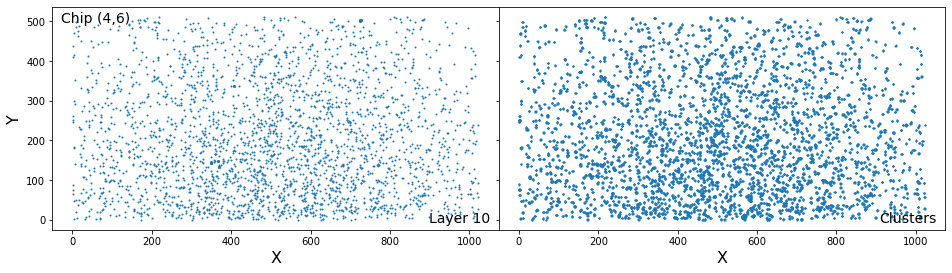

In [14]:
fig, ax = plt.subplots(1,2,figsize=(16,6),sharey=True)
plt.subplots_adjust(wspace=0)

ax[0].scatter(SHitsL10_46['X'],SHitsL10_46['Y'],s=1)
ax[0].set_aspect(1)
ax[0].set_xlabel('X', fontsize=16)
ax[0].set_ylabel('Y', fontsize=16)
ax[0].text(0.02,0.98,'Chip ({0},{1})'.format(chipX,chipY),horizontalalignment='left',verticalalignment='top',transform=ax[0].transAxes,fontsize=14)
ax[0].text(0.98,0.02,'Layer {}'.format(Layer),horizontalalignment='right',verticalalignment='bottom',transform=ax[0].transAxes,fontsize=14)

ax[1].scatter(HtCSL10_46['iX'],HtCSL10_46['iY'],s=1)
ax[1].set_aspect(1)
ax[1].set_xlabel('X', fontsize=16)
#ax[1].text(0.02,0.98,'Chip ({0},{1})'.format(chipX,chipY),horizontalalignment='left',verticalalignment='top',transform=ax[1].transAxes,fontsize=14)
ax[1].text(0.98,0.02,'Clusters',horizontalalignment='right',verticalalignment='bottom',transform=ax[1].transAxes,fontsize=14)

plt.show()

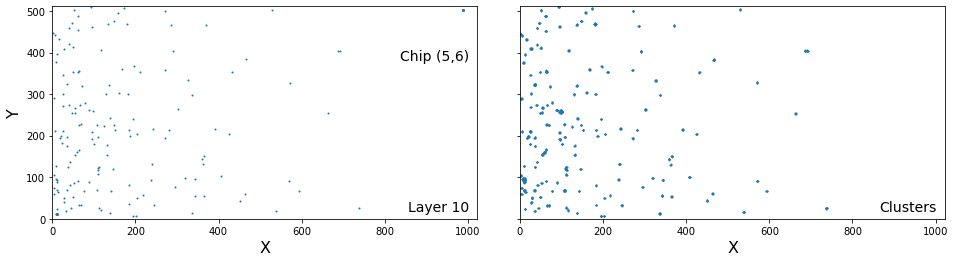

In [15]:
fig, ax = plt.subplots(1,2,figsize=(16,6),sharey=True)
plt.subplots_adjust(wspace=0.1)

plt.xlim(0,1023)
plt.ylim(0,511)

ax[0].scatter(SHitsL10_56['X'],SHitsL10_56['Y'],s=1)
ax[0].set_aspect(1)
ax[0].set_xlim(0,1023)
ax[0].set_xlabel('X', fontsize=16)
ax[0].set_ylabel('Y', fontsize=16)
ax[0].text(0.98,0.8,'Chip ({0},{1})'.format(5,6),horizontalalignment='right',verticalalignment='top',transform=ax[0].transAxes,fontsize=14)
ax[0].text(0.98,0.02,'Layer {}'.format(Layer),horizontalalignment='right',verticalalignment='bottom',transform=ax[0].transAxes,fontsize=14)

ax[1].scatter(HtCSL10_56['iX'],HtCSL10_56['iY'],s=1)
ax[1].set_aspect(1)
ax[1].set_xlabel('X', fontsize=16)
#ax[1].text(0.98,0.98,'Chip ({0},{1})'.format(5,6),horizontalalignment='right',verticalalignment='top',transform=ax[1].transAxes,fontsize=14)
ax[1].text(0.98,0.02,'Clusters',horizontalalignment='right',verticalalignment='bottom',transform=ax[1].transAxes,fontsize=14)

plt.show()

In [938]:
totCS46 = sum(t.get_CS(SHits46['edep']))
totCS56 = sum(t.get_CS(SHits56['edep']))
print('Cluster loss in chip (4,6): {0:.2f}%, in chip (5,6): {1:.2f}%'.format(100.*(1.-len(HtCS46)/totCS46),100.*(1.-len(HtCS56)/totCS56)))

Cluster loss in chip (4,6): 0.46%, in chip (5,6): 0.73%


In [ ]:
# Check layer 26
dfL26 = dfH[dfH['Layer']==26]
Ht26 = Cp.get_Pos_multi(zip(dfL26['posX'],dfL26['posY'],dfL26['edep']))
Ht26_46 = Ht26[(Ht26['col'] == 4) & (Ht26['row'] == 6)]
Ht26CS_46 = Cp.set_CS_multi(zip(Ht26_46['X'],Ht26_46['Y'],Ht26_46['edep']))
len(Ht26CS_46)
# IS ZERO !!!

In [18]:
cs_mean = np.zeros(50)
cs_std = np.zeros(50)
cs_all = 0
cs_25 = 0
for L in range(50):
    t = dfH[dfH['Layer']==L]['edep']
    if(len(t) > 0):
        tt = np.array(Cp.get_CS(t))
        if(len(tt[tt>1]) > 0):
            cs_mean[L] = np.mean(tt[tt>1])
            cs_std[L] = np.std(tt[tt>1])
            cs_all += sum(tt[tt>1])
            if(Layer < 25):
                cs_25 += sum(tt[tt>1])

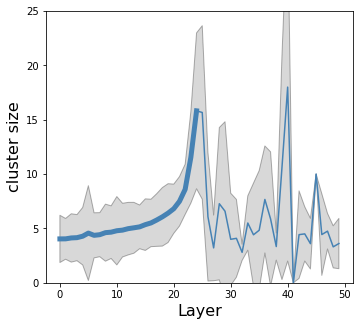

In [19]:
fig, ax = plt.subplots(figsize=(5.5,5))
ax.plot(range(50),cs_mean, color='steelblue')
ax.plot(range(25),cs_mean[0:25], color='steelblue', lw=5)
ax.fill_between(range(50),cs_mean-cs_std,cs_mean+cs_std,facecolor='gray',edgecolor='k',alpha=0.3)
ax.set_xlabel('Layer', fontsize=16)
ax.set_ylabel('cluster size', fontsize=16)
ax.set_ylim(0,25)
plt.show()

In [1110]:
print('Average number of cluster pixels to MC Hits: {0:.2f} (all Layers), {1:.2f} (first 25 Layers)'.format(cs_all/len(dfH), cs_25/len(dfH[dfH['Layer']<25])))
print('Average cluster size (first 25 Layers): {0:.2f}'.format(np.mean(cs_mean[0:25])))

Average number of cluster pixels to MC Hits: 4.71 (all Layers), 4.85 (first 25 Layers)
Average cluster size (first 25 Layers): 5.90


So using cluster reduces the data by a factor of $\approx$ 5 (6-clustersize_information). There is some discrepancy between the numbers I heard
 - uses 50-100 k primaries for one "screenshot"
 - There are on average 200 track for one "screenshot"
 
There are $10^4 - 10^5$ primaries per beamspot (duration 10 ms) and we may have 1000 frames of duration 10$\mu$s, providing 10-100 primaries per frame.

In [20]:
# testing transformation to pixel coords and back
res = Cp.get_Pos(45.02,-14.6,0.03)
print(res)
for i in range(len(res)):
    print(Cp.get_Coords([int(res.iloc[i]['col']), int(res.iloc[i]['row']), res.iloc[i]['X'], res.iloc[i]['Y']]))

   col  row            X           Y  edep
0  5.0  4.0  1022.259918  510.437500  0.03
1  5.0  5.0  1022.259918    0.764881  0.03
[45.02, -14.600000000000001]
[45.02, -14.600000000000001]


In [21]:
dfL16 = dfH[(dfH['Layer']==16)]
Ht16 = Cp.get_Pos_multi(zip(dfL16['posX'],dfL16['posY'],dfL16['edep']))
SHits16_46 = Ht[(Ht['col'] == 4) & (Ht['row'] == 6)]
HtCS16_46 = Cp.set_CS_multi(zip(SHits16_46['X'],SHits16_46['Y'],SHits16_46['edep']))

## End of the 04/12, 2021 presentation, new part comes

lets have a statistics of how many readouts do we have for randomly choosen 200 tracks

In [25]:
Nsample = 300
Lval = [16,20,22,23,24,25]
Pixdict = {}
for i in range(len(Lval)):
    Pixdict[Lval[i]] = []
#for i in range(len(PixDist)):
#    Pixdict[Lval[i]] = np.concatenate([Pixdict[Lval[i]],PixDist[i]])
for L in Lval:
    t = dfH[(dfH['Layer']== L)][['posX','posY','edep']]
    res = np.zeros(Nsample)
    for i in range(Nsample):
        ts = t.sample(n=200)
        Ht = Cp.get_Pos_multi(zip(ts['posX'],ts['posY'],ts['edep']))
        Hsel = Ht[(Ht['col'] == 4) & (Ht['row'] == 6)]
        Hsel_46 = Cp.set_CS_multi(zip(Hsel['X'],Hsel['Y'],Hsel['edep']))
        res[i] = len(Hsel_46)
    Pixdict[L] = np.concatenate([Pixdict[L],res])

In [26]:
[max(Pixdict[L]) for L in Lval]

[414.0, 501.0, 555.0, 801.0, 830.0, 390.0]

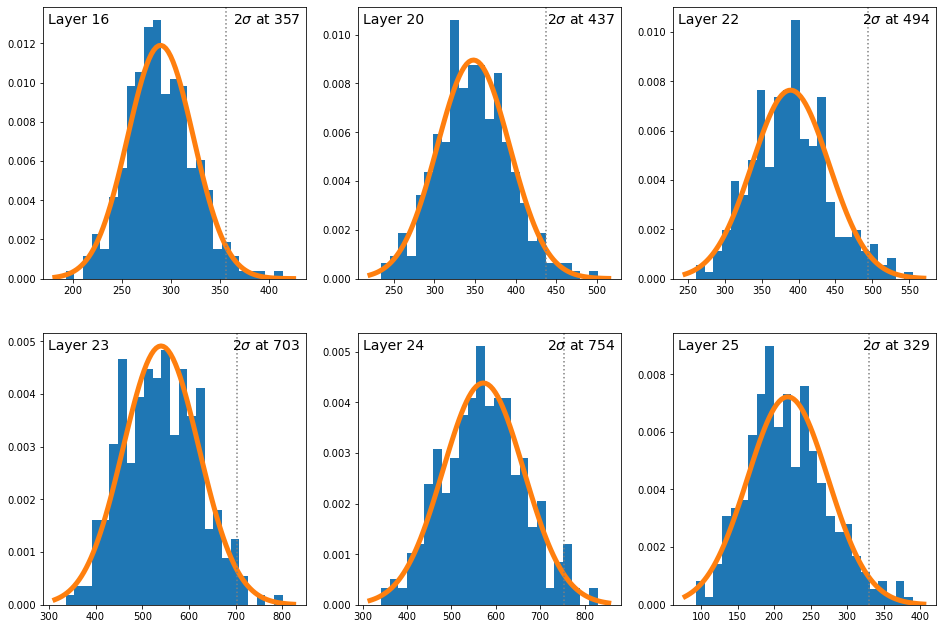

In [27]:
fig, ax = plt.subplots(2,3,figsize=(16,11))

for i in range(6):
    ix = i // 3; iy = i % 3
    ax[ix,iy].hist(Pixdict[Lval[i]],bins=25,density=True)
    sig = np.std(Pixdict[Lval[i]]); mu = np.mean(Pixdict[Lval[i]])
    xx = np.linspace(ax[ix,iy].get_xlim()[0],ax[ix,iy].get_xlim()[1],100)
    yy = np.exp(-(xx-mu)**2/(2.*sig*sig))/np.sqrt(2.*np.pi*sig*sig)
    ax[ix,iy].plot(xx,yy,lw=5)
    ax[ix,iy].text(0.02,0.98,"Layer {}".format(Lval[i]),horizontalalignment='left', verticalalignment='top', transform=ax[ix,iy].transAxes, fontsize=14)
    ax[ix,iy].text(0.98,0.98,r'$2 \sigma$ at {:.0f}'.format(mu+2*sig),horizontalalignment='right', verticalalignment='top', transform=ax[ix,iy].transAxes, fontsize=14)
    ax[ix,iy].axvline(x=mu+2*sig, ls='dotted', color='grey')
plt.show()

Number of activated pixels in one chip at different layers. The 2 $\sigma$ line corresponds to include $\approx$ 98% of the events and gives the maximum number of pixels to be considered for reconstruction.

In [28]:
Nsample = 25
NumPix = pd.DataFrame(columns=['L','mu','std'],dtype=float)
for L in list(set(range(25))-set(Lval)):
    t = dfH[(dfH['Layer']== L)][['posX','posY','edep']]
    res = np.zeros(Nsample)
    for i in range(Nsample):
        ts = t.sample(n=200)
        Ht = Cp.get_Pos_multi(zip(ts['posX'],ts['posY'],ts['edep']))
        Hsel = Ht[(Ht['col'] == 4) & (Ht['row'] == 6)]
        Hsel_46 = Cp.set_CS_multi(zip(Hsel['X'],Hsel['Y'],Hsel['edep']))
        res[i] = len(Hsel_46)
    NumPix = NumPix.append({'L':L,'mu':np.mean(res),'std':np.std(res)},ignore_index=True)
for i in range(len(Lval)):
    L = Lval[i]
    NumPix = NumPix.append({'L':L,'mu':np.mean(Pixdict[L]),'std':np.std(Pixdict[L])},ignore_index=True)

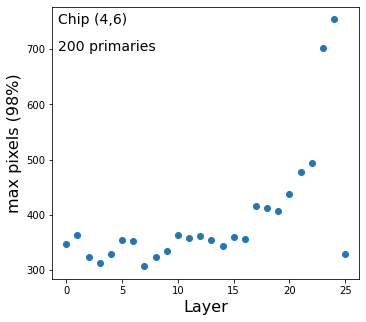

In [29]:
fig, ax = plt.subplots(figsize=(5.5,5))
ax.scatter(NumPix['L'],NumPix['mu']+2*NumPix['std'])
ax.set_xlabel('Layer', fontsize=16)
ax.set_ylabel('max pixels (98%)', fontsize=16)
ax.text(0.02,0.98,'Chip (4,6)',horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, fontsize=14)
ax.text(0.02,0.88,'200 primaries',horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, fontsize=14)

plt.show()
#np.sum([mu+2*std for mu,std in zip(NumPix['mu'],NumPix['std'])])

Maximum number of activated pixels on **one** chip vs layer, for which $\approx$ 98% of events fits. With 800 activated pixels we are safe to work with, for most of the layers and input size of 400 (both for X and Y) is enough.

In [126]:
fig.savefig("numpix.pdf")

## Generating teaching sets

- read the MC root file
- for each hit generate a cluster, store [X,Y,Edep,(x1,y1),(x2,y2),...,(xi,yi)], where X,Y are the hit coordinate, E_dep is the energy deposited, and the rest is a list of the activated pixel points (in pixel coordinates)
- select randomly the number of hits N_hits \in [0,200] and sample N_hits values from the values above (N_hots lines). The [(xi,yi)...] is the input and the [X,Y,Edep] is the 'ground truth'

In [158]:
import pickle
Input_File = "head_input_230MeV.pkl"

#dfH = read_root(f'Data\\MC\\head_phantom_10000Primaries_230MeV_1617471898.root')
#Cp = ConvertToPixels(f'Data\\Cluster\\')

#t = dfH.iloc[0:10]
input_df = pd.DataFrame(columns=['X','Y','edep','Coords'],index=range(len(dfH)))
i=0
for X,Y,Edep in zip(dfH['posX'],dfH['posY'],dfH['edep']):
    for index,row in Cp.get_Pos(X,Y,Edep).iterrows():
        rout = [ [int(r['iX']),int(r['iY'])] for ir,r in Cp.set_CS_multi([[row['X'],row['Y'],Edep]]).iterrows()]
        if(len(rout)>0):
            input_df.iloc[i] = {'X': row['X'], 'Y': row['Y'], 'edep': Edep, 'Coords': [x for xx in rout for x in xx]}
            i += 1

#print(i)
#print(root_df.iloc[0:i])
input_df.drop(np.arange(i,len(input_df))).to_pickle(Input_File)

In [159]:
import pickle
Input_File = "head_input_230MeV.pkl"

with open(Input_File, "rb") as f:
    t = pickle.load(f)
t.iloc[0:10]

,X,Y,edep,Coords
0,419.26287,127.710768,0.019572,"[419, 127, 419, 128, 420, 127, 420, 128]"
1,427.595232,151.812261,0.019803,"[427, 151, 427, 152, 428, 151, 428, 152]"
2,437.942069,173.293278,0.01077,"[437, 173, 438, 173]"
3,440.476163,170.584283,0.016401,"[440, 170, 440, 171, 441, 170]"
4,444.087438,168.515203,0.023339,"[443, 168, 444, 167, 444, 168, 445, 168]"
5,447.376228,164.827521,0.019887,"[447, 164, 447, 165, 448, 164, 448, 165]"
6,448.654834,157.303055,0.024088,"[447, 157, 447, 158, 447, 159, 448, 158]"
7,451.464336,149.105891,0.015078,"[451, 148, 452, 148, 452, 149]"
8,452.606181,140.843712,0.020345,"[452, 140, 452, 141, 453, 140, 453, 141]"
9,453.455327,132.579403,0.020335,"[453, 132, 453, 133, 454, 132, 454, 133]"


In [160]:
len(t)

177820

In [9]:
file = uproot.open(f'Data\\Cluster\\'+f'\\database_final_reduced.root')
tree = file[file.keys()[0]]
CSconfigs = pd.DataFrame(tree.arrays(library='np', how=tuple)).transpose()
CSconfigs.columns =tree.keys()
file.close()
CSindex = pd.read_csv(f'Data\\Cluster\\'+f'\\sortIndex.csv',sep=' ',header=0,names=['cs','start'])


In [36]:
f = open("test.txt",'w')
for index,t in CSconfigs.iterrows():
    tt = np.concatenate(([t['x_mean'],t['y_mean'],t['size']],t['hit_array']))
    f.write(' '.join(map(str,tt)))
    f.write('\n')
f.close()

In [39]:
dfH.head()

,PDGEncoding,trackID,parentID,trackLocalTime,time,edep,stepLength,trackLength,posX,posY,...,sourcePosZ,sourceID,eventID,runID,axialPos,rotationAngle,volumeID,processName,comptVolName,RayleighVolName
0,2212,1,0,0.0,0.0,0.019572,0.025003,725.273071,-2.711634,4.312305,...,-500.0,0,0,0,277.399994,0.0,"[0, 1, 0, 3, -1, -1, -1, -1, -1, -1]",Transportation,NULL,NULL
1,2212,1,0,0.0,0.0,0.019803,0.025002,777.677612,-2.467995,4.960154,...,-500.0,0,0,0,277.399994,0.0,"[0, 1, 1, 3, -1, -1, -1, -1, -1, -1]",Transportation,NULL,NULL
2,2212,1,0,0.0,0.0,0.01077,0.025005,833.43158,-2.165454,5.537563,...,-500.0,0,0,0,461.799988,0.0,"[0, 2, 0, 3, -1, -1, -1, -1, -1, -1]",Transportation,NULL,NULL
3,2212,1,0,0.0,0.0,0.016401,0.025006,838.932678,-2.091357,5.464746,...,-500.0,0,0,0,461.799988,0.0,"[0, 2, 1, 3, -1, -1, -1, -1, -1, -1]",Transportation,NULL,NULL
4,2212,1,0,0.0,0.0,0.023339,0.025007,844.434082,-1.985763,5.409129,...,-500.0,0,0,0,461.799988,0.0,"[0, 2, 2, 3, -1, -1, -1, -1, -1, -1]",Transportation,NULL,NULL
